# Import libraries

In [60]:
import numpy as np
import pandas as pd
from datetime import datetime
from fuzzywuzzy import process, fuzz
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

from pandas_profiling import ProfileReport

When we first tried to load the csv file into a dataframe, we got this error 
ParserError: Error tokenizing data. C error: Expected 12 fields in line 3350, saw 13

Meaning that at row 3350, there is an extra column. We modified the file trough excel where we've noticed that the columns were shifted to the right. The same for the rows 4704,5879 and 8981  

# IMPORT DATA

In [93]:
#import book dataset
df=pd.read_csv("C:/Users/romai/Documents/DSTI/4-Python Labs/Project/Python/dataset/books_v2.csv", index_col="bookID", on_bad_lines = 'error')

# EXPLORATORY DATA ANALYSIS
1. Create a EDA summary report using Pandas Profiling
2. Describe the data
3. Look for missing values
4. Look for "weird" values (outliers? errors?)
5. Check if data are balanced (if not, model can be biaise

## 1. Initial EDA summary report 
using Pandas Profiling library

In [94]:
# Generate the profile report with Pandas Profiling
profile = ProfileReport(
    df,
    title="Summarization of book rating data")

In [95]:
# Generate the dataset profile
# This is a nice and simple way to document the data
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 2. Traditional EDA

In [96]:
#Return first 5 rows of the dataset
df.head(5)

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,9.780000e+12,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,9.780000e+12,eng,870,2153167,29221,09/01/2004,Scholastic Inc.
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,439554896,9.780000e+12,eng,352,6333,244,11/01/2003,Scholastic
5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9.780000e+12,eng,435,2339585,36325,05/01/2004,Scholastic Inc.
8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,439682584,9.780000e+12,eng,2690,41428,164,9/13/2004,Scholastic


Publication dates have different formats

isbn and isbn13 relevant for our model? Does a barcode can predict the ratings? In general, related to year of publication and identification of book (information that we already have) + we strongly assume that a reader doesn't look at that information when he/she evaluates a book (neither to select a book in order to read it) 
=> we decide to remove it from our future model

Authors: single author vs multiple authors -> new column "Authors_2" = Single/Multiple -> boolean

In [97]:
df.shape

(11127, 11)

In [98]:
df.columns

Index(['title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code',
       '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

We can see a space upfront the column name "num_pages"

=>  **Action (Feature Eng)**: remove space upfront " num_pages"
***

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11127 entries, 1 to 45641
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               11127 non-null  object 
 1   authors             11127 non-null  object 
 2   average_rating      11127 non-null  float64
 3   isbn                11127 non-null  object 
 4   isbn13              11127 non-null  float64
 5   language_code       11127 non-null  object 
 6     num_pages         11127 non-null  int64  
 7   ratings_count       11127 non-null  int64  
 8   text_reviews_count  11127 non-null  int64  
 9   publication_date    11127 non-null  object 
 10  publisher           11127 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 1.3+ MB


In [100]:
#Columns type
df.dtypes

title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                float64
language_code          object
  num_pages             int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

In [101]:
#Is there any NA values in the dataset?
df.isna().sum()

title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

In [102]:
#check for row duplication
df.duplicated().sum()

#no duplicate row but let's look at such as title, authors, etc (later) that could be repeated

0

In [104]:
#Exploring statistical summary for numerical columns and some information for non-numerical columns 
df.describe(include = "all")

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
count,11127,11127,11127.000000,11127,1.112700e+04,11127,11127.000000,1.112700e+04,11127.000000,11127,11127
unique,10352,6643,NaN,11127,NaN,27,NaN,NaN,NaN,3682,2292
top,The Brothers Karamazov,Stephen King,NaN,439785960,NaN,eng,NaN,NaN,NaN,10/01/2005,Vintage
freq,9,40,NaN,1,NaN,8911,NaN,NaN,NaN,56,318
mean,NaN,NaN,3.933631,NaN,9.759178e+12,NaN,336.376921,1.793641e+04,541.854498,NaN,NaN
std,NaN,NaN,0.352445,NaN,4.428650e+11,NaN,241.127305,1.124794e+05,2576.176608,NaN,NaN
min,NaN,NaN,0.000000,NaN,8.987060e+09,NaN,0.000000,0.000000e+00,0.000000,NaN,NaN
25%,NaN,NaN,3.770000,NaN,9.780000e+12,NaN,192.000000,1.040000e+02,9.000000,NaN,NaN
50%,NaN,NaN,3.960000,NaN,9.780000e+12,NaN,299.000000,7.450000e+02,46.000000,NaN,NaN
75%,NaN,NaN,4.135000,NaN,9.780000e+12,NaN,416.000000,4.993500e+03,237.500000,NaN,NaN


* Books with no pages (76 of them) -> how it's possible ? replace by mean in FE

* Average rating equal to 0 is possible

* Ratings_count = 0 -> irrelevant if there is an average rating not null- remove in FE
* Unique title < total count -> duplicate titles - how to deal with that?

***

In [105]:
#What are the books that have 0 pages?  
pages = df['  num_pages']
df[pages == 0]

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
955,The 5 Love Languages / The 5 Love Languages Jo...,Gary Chapman,4.70,802415318,9.780000e+12,eng,0,22,4,01/01/2005,Moody Publishers
2835,The Tragedy of Pudd'nhead Wilson,Mark Twain/Michael Prichard,3.79,140015068X,9.780000e+12,eng,0,3,0,01/01/2003,Tantor Media
3593,Murder by Moonlight & Other Mysteries (New Adv...,NOT A BOOK,4.00,743564677,9.780000e+12,eng,0,7,2,10/03/2006,Simon Schuster Audio
3599,The Unfortunate Tobacconist & Other Mysteries ...,NOT A BOOK,3.50,074353395X,9.780000e+12,eng,0,12,1,10/01/2003,Simon & Schuster Audio
4249,The Da Vinci Code (Robert Langdon #2),Dan Brown/Paul Michael,3.84,739339788,9.780000e+12,eng,0,91,16,3/28/2006,Random House Audio
...,...,...,...,...,...,...,...,...,...,...,...
40378,The Chessmen of Mars (Barsoom #5),Edgar Rice Burroughs/John Bolen,3.83,1400130212,9.780000e+12,eng,0,5147,157,01/01/2005,Tantor Media
41273,Fine Lines (One-Eyed Mack #6),Jim Lehrer,3.23,517164353,9.780000e+12,eng,0,17,4,11/19/1995,Random House Value Publishing
43343,Stowaway and Milk Run: Two Unabridged Stories ...,Mary Higgins Clark/Jan Maxwell,3.49,671046241,9.780000e+12,eng,0,64,2,12/01/1999,Simon & Schuster Audio


=>  **Action (Feature Eng)**: replacing the 'num_pages' 0 values with the mean and checking the result
***

/!\ What does it mean NOT A BOOK in the authors column? bookID:3593, 3599 <br>
Let's look at it in more details if we have others "NOT A BOOK" authors

In [133]:
df[df.authors == 'NOT A BOOK']
#there are 5 books with "Not a Book" which are Audio Book -> suggestion to drop them

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
3593,Murder by Moonlight & Other Mysteries (New Adv...,NOT A BOOK,4.00,743564677,9.780000e+12,eng,0,7,2,2006-10-03,Simon Schuster Audio
3599,The Unfortunate Tobacconist & Other Mysteries ...,NOT A BOOK,3.50,074353395X,9.780000e+12,eng,0,12,1,2003-10-01,Simon & Schuster Audio
19786,The Goon Show Volume 4: My Knees Have Fallen ...,NOT A BOOK,5.00,563388692,9.780000e+12,eng,2,3,0,1996-04-01,BBC Physical Audio
19787,The Goon Show: Moriarty Where Are You?,NOT A BOOK,4.43,563388544,9.780000e+12,eng,2,0,0,2005-03-30,BBC Physical Audio
19788,The Goon Show Volume 11: He's Fallen in the W...,NOT A BOOK,5.00,563388323,9.780000e+12,eng,2,2,0,1995-10-02,BBC Physical Audio


=> **Action (Feature Eng)**:  remove those 5 rows
***

In [134]:
#describe our target variable average_rating and plot it
df.average_rating.describe()

count    11127.000000
mean         3.933631
std          0.352445
min          0.000000
25%          3.770000
50%          3.960000
75%          4.135000
max          5.000000
Name: average_rating, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

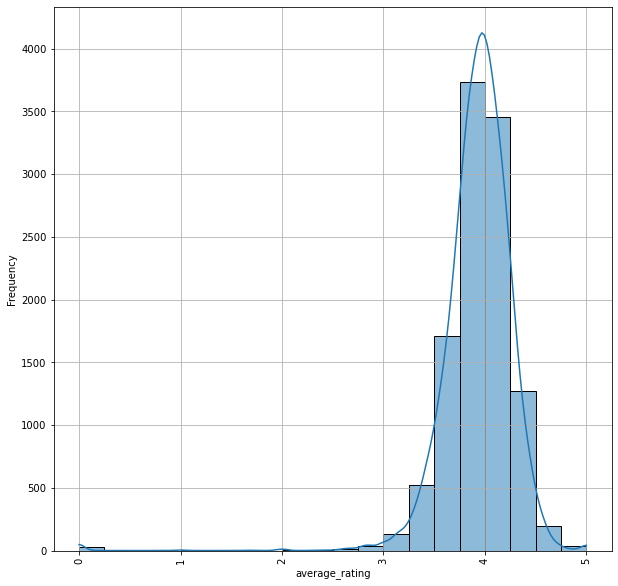

In [123]:
plt.figure(figsize=(10,10))
sns.histplot(df['average_rating'], kde = True, bins = 20, palette = "hls" )
plt.xticks(rotation = 90)
plt.ylabel('Frequency')
plt.grid()
plt.show

In [147]:
#median 
print("Median (average_rating):", df.average_rating.median())
print("Mean (average_rating): ", df.average_rating.mean())

Median (average_rating): 3.96
Mean (average_rating):  3.9336308079446125


In [135]:
#check the normality of the distribution
print(f"Skewness: {df['average_rating'].skew()}")
print(f"Kurtosis: {df['average_rating'].kurt()}")

Skewness: -3.638311410554902
Kurtosis: 36.721776547302916


Asymetry in distribution with outliers (https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de):
* A negative skewness value in the output indicates an asymmetry in the distribution corresponding to row 2 and the tail is larger towards the left hand side of the distribution.

* High kurtosis in a data set is an indicator that data has heavy outliers. 

=> **Action (Feature Eng)**: create 3 categories ([0-2]-[3]-[4-5])
***

### Study of relationships between variables

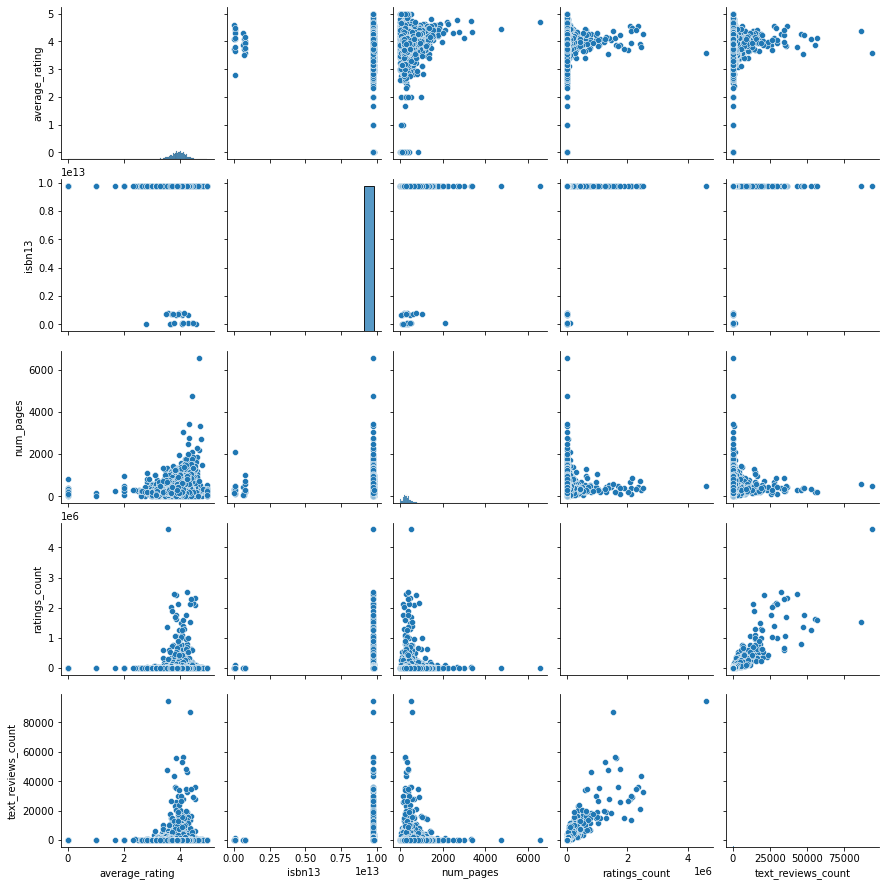

In [139]:
sns.pairplot(df) #numeric variables

## 3. Data Cleaning  

### Columns title

In [106]:
#Renaming '  num_pages' in order to remove the extra spaces and displaying columns names
df.rename(columns={'  num_pages':'num_pages'}, inplace=True)

In [107]:
df.columns

Index(['title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code',
       'num_pages', 'ratings_count', 'text_reviews_count', 'publication_date',
       'publisher'],
      dtype='object')

### Languages
For the language_code column, replacing the value eng-US, en-CA and eng-GB with the value eng 

In [108]:
df.language_code.value_counts()

eng      8911
en-US    1409
spa       218
en-GB     214
fre       144
ger        99
jpn        46
mul        19
zho        14
grc        11
por        10
en-CA       7
ita         5
enm         3
lat         3
swe         2
rus         2
srp         1
nl          1
msa         1
glg         1
wel         1
ara         1
nor         1
tur         1
gla         1
ale         1
Name: language_code, dtype: int64

In [109]:
df['language_code'] = df['language_code'].replace('en-US','eng')
df['language_code'] = df['language_code'].replace('en-GB','eng')
df['language_code'] = df['language_code'].replace('en-CA','eng')

#or

#df.language_code = books_df.language_code.replace({'en-US':'eng', 'en-GB':'eng', 'en-CA':'eng'})

In [110]:
df.language_code.value_counts()

eng    10541
spa      218
fre      144
ger       99
jpn       46
mul       19
zho       14
grc       11
por       10
ita        5
lat        3
enm        3
rus        2
swe        2
nl         1
ara        1
srp        1
msa        1
glg        1
wel        1
nor        1
tur        1
gla        1
ale        1
Name: language_code, dtype: int64

### Publisher columns, many publishers have different spellings

In [136]:
pub = df.publisher.unique()
elements = list(pub)
# elements = ['vikash', 'vikas', 'Vinod', 'Vikky', 'Akash', 'Vinodh', 'Sachin', 'Salman', 'Ajay', 'Suchin', 'vIkas', 'salman', 'salMa', 'Akash', 'vikahs']

results = [[name, [], 0] for name in elements]

for (i, element) in enumerate(elements):
    for (j, choice) in enumerate(elements[i+1:]):
        if fuzz.ratio(element, choice) >= 90:
            results[i][2] += 1
            results[i][1].append(choice)
            results[j+i+1][2] += 1
            results[j+i+1][1].append(element)

data = pd.DataFrame(results, columns=['name', 'duplicates', 'duplicate_count'])

data = data.sort_values(by=['duplicate_count'],ascending=False)


In [137]:
to_remove = []
test = {}

for i,j in data.iterrows():
    if data.name[i] in list(test.keys()):
        for x in j.duplicates:
            if x not in test : 
                test[x]=test[data.name[i]]
    else : 
        test[data.name[i]] = data.name[i]
        for x in j.duplicates:
            if x not in test : 
                test[x]=data.name[i]
#                 print(data.name[i], "****", x,"--" , data.name[i])
        

                    
# print(test)
data['pub'] = data['name'].map(test)
display(data)

,name,duplicates,duplicate_count,pub
102,W. W. Norton & Company,"[W. W. Norton Company, W.W. Norton & Company,...",4,W. W. Norton & Company
815,W.W. Norton Company,"[W. W. Norton & Company, W. W. Norton Company...",4,W. W. Norton & Company
120,W. W. Norton Company,"[W. W. Norton & Company, W.W. Norton & Company...",4,W. W. Norton & Company
1722,Farrar Straus & Giroux,"[Farrar Straus and Giroux, Farrar Straus Giro...",3,Farrar Straus & Giroux
1419,W. W. Norton and Company,"[W. W. Norton & Company, W. W. Norton Company...",3,W. W. Norton & Company
...,...,...,...,...
825,Albury Publishing,[],0,Albury Publishing
824,Little Brown Young Readers,[],0,Little Brown Young Readers
823,Random House Value Publishing,[],0,Random House Value Publishing
822,Holt McDougal,[],0,Holt McDougal


In [140]:
df['publisher_iso'] = df['publisher'].map(test)

In [141]:
len(df.publisher_iso.unique())

2144

In [142]:
df.head(5)

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publisher_iso
bookID,,,,,,,,,,,,
1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,9.780000e+12,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,Scholastic Inc.
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,9.780000e+12,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,Scholastic Inc.
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,439554896,9.780000e+12,eng,352,6333,244,2003-11-01,Scholastic,Scholastic
5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9.780000e+12,eng,435,2339585,36325,2004-05-01,Scholastic Inc.,Scholastic Inc.
8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,439682584,9.780000e+12,eng,2690,41428,164,2004-09-13,Scholastic,Scholastic


In [112]:
df.publisher.value_counts()

Vintage                        318
Penguin Books                  261
Penguin Classics               184
Mariner Books                  150
Ballantine Books               144
                              ... 
University of Calgary Press      1
Marlowe & Company                1
University Press of America      1
Abstract Studio                  1
Sounds True                      1
Name: publisher, Length: 2292, dtype: int64

In [150]:
group=df.groupby('publisher')['title'].count().reset_index().sort_values('title', ascending = False).set_index('publisher')
group

,title
publisher,
Vintage,318
Penguin Books,261
Penguin Classics,184
Mariner Books,150
Ballantine Books,144
...,...
Hub City Press,1
Howard University Press,1
Howard Publishing Co,1


### Date Column
**move to FEATURE ENGINEERING

In [113]:
# Changing the publication_date colummn type to a date format 
df['publication_date'] = pd.to_datetime(df['publication_date'], dayfirst = False, yearfirst = False, errors = 'coerce')

In [120]:
df.head(5)

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,9.780000e+12,eng,652,2095690,27591,2006-09-16,Scholastic Inc.
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,9.780000e+12,eng,870,2153167,29221,2004-09-01,Scholastic Inc.
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,439554896,9.780000e+12,eng,352,6333,244,2003-11-01,Scholastic
5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9.780000e+12,eng,435,2339585,36325,2004-05-01,Scholastic Inc.
8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,439682584,9.780000e+12,eng,2690,41428,164,2004-09-13,Scholastic


In [114]:
df.isna().sum()

title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      2
publisher             0
dtype: int64

In [115]:
df.loc[df.publication_date.isna(),:]

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
31373,In Pursuit of the Proper Sinner (Inspector Lyn...,Elizabeth George,4.10,553575104,9.780000e+12,eng,718,10608,295,NaT,Bantam Books
45531,Montaillou village occitan de 1294 à 1324,Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie,3.96,2070323285,9.780000e+12,fre,640,15,2,NaT,Folio histoire


those 2 dates are unreal in the sense that
    # November doesn't have 31 days (11/31/2000)
    # June doesn't have 31 days (31/06/1982)
    
=> replace by correct date for those 2 rows

    #31373 published October 31, 2000 by Bantam Books (https://www.goodreads.com/book/show/31373.In_Pursuit_of_the_Proper_Sinner?ac=1&from_search=true&qid=3A5Zotzgsy&rank=1)
    
    #45531 published June 30, 1982 by Folio histoire (https://www.goodreads.com/book/show/45531.Montaillou_village_occitan_de_1294_1324)

In [119]:
#correcting 2 NaT by correct date
df.loc[31373,"publication_date"]='10/30/2000'
df.loc[45531,"publication_date"] ='6/30/1982'
df.loc[[31373,45531]]

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
31373,In Pursuit of the Proper Sinner (Inspector Lyn...,Elizabeth George,4.10,553575104,9.780000e+12,eng,718,10608,295,2000-10-30,Bantam Books
45531,Montaillou village occitan de 1294 à 1324,Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie,3.96,2070323285,9.780000e+12,fre,640,15,2,1982-06-30,Folio histoire


In [ ]:
# Splitting date column into month and year columns - move in FE 
df['month'] = df['publication_date'].dt.month
df['year'] = df['publication_date'].dt.year

In [1]:
# bookID: 31373 where the date value before converting the column into a datetime type was 11/31/2000 (30 days for November)
# bookID: 45531 where the date value before converting the column into a datetime type was 6/31/1982 (30 days for June)
# Dropping those 2 rows 
#df = df.drop(index=df.loc[df.publication_date.isna(),:].index)

NameError: name 'df' is not defined

# Next Steps

1. In the correlation section
   * Avg rating // language (visual)
   * Avg rating for top published authors over time (year) (bof)
   * Avg rating for top publishers over time (bof)
   * Corr month publication // avg rating / rating counts / text review
   * Corr year publication // avg rating / rating counts / text review
   

2. jointplot for text_reviews_count and ratings_count --> no histogram 

3. After dropping all outliers, how does the heatmap look like? 

4. Transforming categorical columns into numerical columns 
    * Title
    * Authors 
    * Language 
    * Publisher 

5. New column that identifies if the book has been written by a single or multiple authors
    Or trying to select only the first author of the book 

6. Identify similar publishers ??? 

7. Dropping the rows where the avg rating is 0

8. Dropping the rows where rating counts and text review counts are set to 0